# GAN

This section consists of vanilla GAN and LSGAN implementation. The general structure for GAN is given below.

In [5]:
!nvidia-smi
# This command should return some information about the GPU status if the runtime is right. 
# In addition to that, if you encounter memory issues, you can diagnose your model by this command.

Sun Dec  9 21:21:42 2018       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 396.44                 Driver Version: 396.44                    |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|===============================+======================+======================|
|   0  Tesla K80           Off  | 00000000:00:04.0 Off |                    0 |
| N/A   44C    P0    72W / 149W |    374MiB / 11441MiB |      0%      Default |
+-------------------------------+----------------------+----------------------+
                                                                               
+-----------------------------------------------------------------------------+
| Processes:                                                       GPU Memory |
|  GPU  

In [ ]:
!pip3 install torch==0.4.1
!pip3 install torchvision==0.2.1
!pip3 install Pillow==4.0.0
!pip3 install scipy
!pip3 install numpy
!pip3 install matplotlib

In [0]:
import torch
from torch import nn, optim
from torchvision import transforms, datasets
from torch.autograd.variable import Variable
import torchvision.utils as vutils
import numpy as np
import matplotlib.pyplot as plt
import os

# Download and load the Fashion MNIST data as instructed below

In [0]:
def fashion_mnist_data():
    compose = transforms.Compose(
        [transforms.ToTensor(),
         transforms.Normalize((.5, .5, .5), (.5, .5, .5))
        ])
    out_dir = '.OUTPUT_PATH'
    return datasets.FashionMNIST(root=out_dir, train=True, transform=compose, download=True)

# You can change the Batchsize Parameter below if you want

In [0]:
# Load data
data = fashion_mnist_data()
# Create loader with data, so that we can iterate over it
data_loader = torch.utils.data.DataLoader(data, batch_size=100, shuffle=True)
# Num batches
num_batches = len(data_loader)
MODEL_PATH = '/PATH/model/gan'
if not os.path.exists(MODEL_PATH): os.makedirs(MODEL_PATH)

# Discriminator Architecture

Please note: Pay attention to whether Sigmoid Unit at the last layer is added in the Architecture OR in the Loss function, because in implementations of some loss functions in Pytorch, sigmoid unit is included by default.

In [0]:
class DiscriminatorNet(torch.nn.Module):
    def __init__(self):
        super(DiscriminatorNet, self).__init__()
        n_features = 784
        n_out = 1
        
        self.hidden0 = nn.Sequential( 
            nn.Linear(n_features, 1024),
            nn.LeakyReLU(0.2),
            nn.Dropout(0.3)
        )
        self.hidden1 = nn.Sequential(
            nn.Linear(1024, 512),
            nn.LeakyReLU(0.2),
            nn.Dropout(0.3)
        )
        self.hidden2 = nn.Sequential(
            nn.Linear(512, 256),
            nn.LeakyReLU(0.2),
            nn.Dropout(0.3)
        )
        self.out = nn.Sequential(
            torch.nn.Linear(256, n_out),
            torch.nn.Sigmoid()
        )

    def forward(self, x):
        x = self.hidden0(x)
        x = self.hidden1(x)
        x = self.hidden2(x)
        x = self.out(x)
        return x

# Utility function for flattenning and unflattenning of images to vectors and vice versa

In [0]:
def images_to_vectors(images):
    return images.view(images.size(0), 784)

def vectors_to_images(vectors):
    return vectors.view(vectors.size(0), 1, 28, 28)

# Generator Architecture

In [0]:
class GeneratorNet(torch.nn.Module):
    def __init__(self):
        super(GeneratorNet, self).__init__()
        n_features = 100
        n_out = 784
        
        self.hidden0 = nn.Sequential(
            nn.Linear(n_features, 256),
            nn.LeakyReLU(0.2)
        )
        self.hidden1 = nn.Sequential(            
            nn.Linear(256, 512),
            nn.LeakyReLU(0.2)
        )
        self.hidden2 = nn.Sequential(
            nn.Linear(512, 1024),
            nn.LeakyReLU(0.2)
        )
        
        self.out = nn.Sequential(
            nn.Linear(1024, n_out),
            nn.Tanh()
        )

    def forward(self, x):
        x = self.hidden0(x)
        x = self.hidden1(x)
        x = self.hidden2(x)
        x = self.out(x)
        return x

# Generate the input noise distribution to your generator

In [0]:
def noise(size):
    """
    Generate noise
    """
    n = Variable(torch.randn(size, 100))
    return n

# VanillaGAN uses Binary Cross Entropy loss, instatiated below. Also Least Squares loss implemented for LS GAN below

In [0]:
VanillaGAN = nn.BCELoss()
LSGAN = nn.MSELoss()

# Optional lines below, you can either use them or implement yours inline in your training loop

In [0]:
def ones_target(size):
    '''
    Tensor containing ones, with shape = size
    '''
    data = torch.ones(size, 1).to('cuda')
    return data

def zeros_target(size):
    '''
    Tensor containing zeros, with shape = size
    '''
    data = torch.zeros(size, 1).to('cuda')
    return data

In [0]:
def train_discriminator(discriminator, optimizer, loss, real_data, fake_data):
    N = real_data.size(0)
    
    optimizer.zero_grad()
    
    # Train Real Data
    prediction_real = discriminator(real_data)
    error_real = loss(prediction_real, ones_target(N) )
    error_real.backward()

    # Train Fake Data
    prediction_fake = discriminator(fake_data)
    error_fake = loss(prediction_fake, zeros_target(N))
    error_fake.backward()
    
    optimizer.step()
    
    return error_real + error_fake

In [0]:
def train_generator(discriminator, optimizer, loss, fake_data):
    N = fake_data.size(0)

    optimizer.zero_grad()
    
    prediction = discriminator(fake_data)
    error = loss(prediction, ones_target(N))
    error.backward()

    optimizer.step()

    return error

In [0]:
num_test_samples = 16
test_noise = noise(num_test_samples).cuda()

In [0]:
def train(loss_type):
    if loss_type == 'VanillaGAN':
      loss = VanillaGAN
    else:
      loss = LSGAN
    discriminator = DiscriminatorNet().to('cuda')
    generator = GeneratorNet().to('cuda')
    
    d_optimizer = optim.Adam(discriminator.parameters(), lr=0.0002, betas=(0.5, 0.999))
    g_optimizer = optim.Adam(generator.parameters(), lr=0.0002, betas=(0.5, 0.999))
    
    d_error_list = []
    g_error_list = []
    img_list = []
    
    num_epochs = 30

    for epoch in range(num_epochs):
        d_error_total = 0.0
        g_error_total = 0.0
        for n_batch, (real_batch,_) in enumerate(data_loader):
            N = real_batch.size(0)
            # -----------------
            #  Train Discriminator
            # -----------------
            real_data = Variable(images_to_vectors(real_batch)).cuda()
            fake_data = generator(noise(N).cuda()).detach()
            d_error = train_discriminator(discriminator, d_optimizer, loss, real_data, fake_data)
            # -----------------
            #  Train Generator
            # -----------------
            fake_data = generator(noise(N).cuda())
            g_error = train_generator(discriminator, g_optimizer, loss, fake_data)

            if (n_batch + 1) % 100 == 0: 
                test_data = generator(test_noise)

                print("epoch: {%d}, batch number: {%d}, d_error: {%.4f}, g_error: {%.4f}" % 
                      (epoch + 1, n_batch + 1, d_error.item(), g_error.item()))
                
            d_error_total = d_error_total + d_error.item()
            g_error_total = g_error_total + g_error.item()
            
        d_error_list.append(d_error_total/len(data_loader))
        g_error_list.append(g_error_total/len(data_loader))
        # Save your model weights
        if (epoch + 1) % 10 == 0:
            save_dict = {
                'g': generator.state_dict(), 
                'd': discriminator.state_dict()
            }
            if loss_type == 'VanillaGAN':
                torch.save(save_dict, '{}/VanillaGAN_{}.pth.tar'.format(MODEL_PATH, epoch+1))
            else:
                torch.save(save_dict, '{}/LSGAN_{}.pth.tar'.format(MODEL_PATH, epoch+1))
        
        test_images = vectors_to_images(test_data).data
        img_list.append(test_images)
    return d_error_list, g_error_list, img_list
  

In [14]:
print("VanillaGAN Training")
d_vanilla, g_vanilla, img_vanilla = train('VanillaGAN')

print("LSGAN Training")
d_lsgan, g_lsgan, img_lsgan = train('LSGAN')

VanillaGAN Training
epoch: {1}, batch number: {100}, d_error: {0.1122}, g_error: {3.0111}
epoch: {1}, batch number: {200}, d_error: {0.2786}, g_error: {4.4474}
epoch: {1}, batch number: {300}, d_error: {0.7684}, g_error: {1.9040}
epoch: {1}, batch number: {400}, d_error: {0.6157}, g_error: {4.0826}
epoch: {1}, batch number: {500}, d_error: {0.6204}, g_error: {2.5163}
epoch: {1}, batch number: {600}, d_error: {0.5157}, g_error: {3.2195}
epoch: {2}, batch number: {100}, d_error: {0.7830}, g_error: {1.7861}
epoch: {2}, batch number: {200}, d_error: {0.5750}, g_error: {2.0827}
epoch: {2}, batch number: {300}, d_error: {0.4967}, g_error: {1.9099}
epoch: {2}, batch number: {400}, d_error: {0.6458}, g_error: {2.6889}
epoch: {2}, batch number: {500}, d_error: {0.7023}, g_error: {2.1254}
epoch: {2}, batch number: {600}, d_error: {0.7117}, g_error: {2.0659}
epoch: {3}, batch number: {100}, d_error: {0.6586}, g_error: {1.9132}
epoch: {3}, batch number: {200}, d_error: {0.8063}, g_error: {2.7386}


## Training loss curves and test results (generated images) for both vanillaGAN and LSGAN.

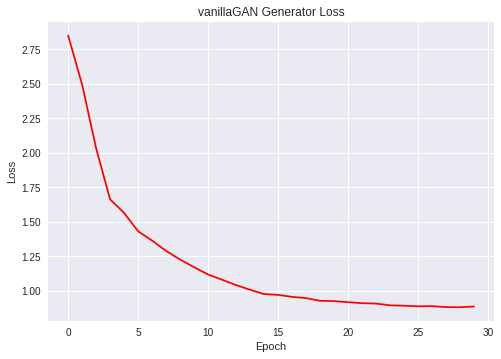

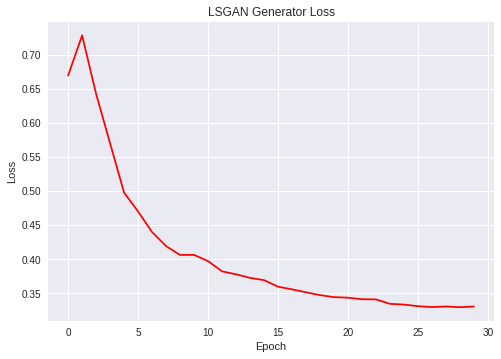

In [15]:
# Plot Generator Loss

# vanillaGAN
plt.plot(g_vanilla, 'r')
plt.title('vanillaGAN Generator Loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.show()

# LSGAN
plt.plot(g_lsgan, 'r')
plt.title('LSGAN Generator Loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.show()

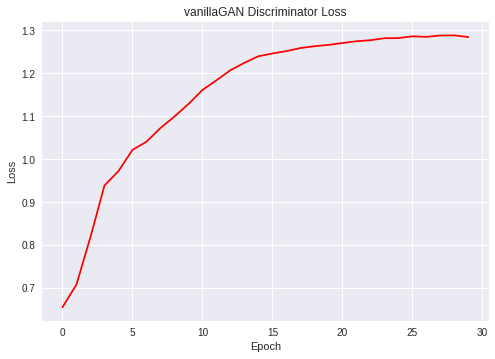

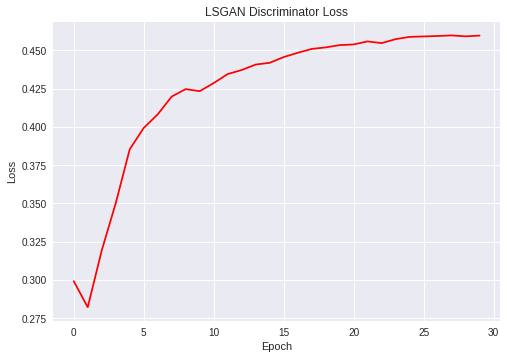

In [16]:
# Plot Discriminator Loss

# vanillaGAN
plt.plot(d_vanilla, 'r')
plt.title('vanillaGAN Discriminator Loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.show()

# LSGAN
plt.plot(d_lsgan, 'r')
plt.title('LSGAN Discriminator Loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.show()

In [17]:
'''
As a result
LSGAN seems to overcome the vanishing gradients problem during the learning process for the discriminator. 
LSGAN minimaze the divergence over Vanilla Gan and also LSGAN generates higher quality images than Vanilla Gan.
Also LSGAN performs more stable during the learning process.
'''

for i,_ in enumerate(img_vanilla):
  plt.figure(figsize=(16,16))
  plt.subplot(1,2,1)
  plt.axis("off")
  plt.title("vanillaGAN (Generated) Epoch: %d" % (i + 1))
  plt.imshow(np.transpose(vutils.make_grid(img_vanilla[i], padding=5, normalize=True),(1,2,0)))

  plt.subplot(1,2,2)
  plt.axis("off")
  plt.title("LSGAN (Generated) Epoch: %d" % (i + 1))
  plt.imshow(np.transpose(vutils.make_grid(img_lsgan[i], padding=5, normalize=True),(1,2,0)))
  plt.show()

Output hidden; open in https://colab.research.google.com to view.